In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import tensorflow as tf
from collections import Counter
%matplotlib inline

## Data Preprocessing

In [2]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', 
                                  shuffle=True, random_state=11)
newsgroups_test = fetch_20newsgroups(subset='test', 
                                  shuffle=True, random_state=11)
#newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'),
#                                  shuffle=True, random_state=11)
#newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'),
#                                  shuffle=True, random_state=11)

In [3]:
print('Training text number:', len(newsgroups_train.data))
print('Testing text number:', len(newsgroups_test.data))

Training text number: 11314
Testing text number: 7532


## News to IDs

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
class readNews:
    '''
    Read 20news and transform them into vectors for training
    Args:
    train_data
    test_data
    '''
    def __init__(self, train_data, test_data):
        self._train_data = train_data
        self._test_data = test_data
        self._preprocess()
    
    
    def _preProcessor(self, s):
        #remove punctuation
        s = re.sub('['+string.punctuation+']', ' ', s)
        #remove digits
        s = re.sub('['+string.digits+']', ' ', s)
        #remove foreign characters
        s = re.sub('[^a-zA-Z]', ' ', s)
        #remove line ends
        s = re.sub('\n', ' ', s)
        #turn to lower case
        s = s.lower()
        s = re.sub('[ ]+',' ', s)
        s = s.rstrip()
        return s
    
    def _preprocess(self):
        '''Remove punctuations'''
        train_news = self._train_data.data
        test_news = self._test_data.data
        self._train_data.data = [self._preProcessor(item) for item in train_news]
        self._test_data.data = [self._preProcessor(item) for item in test_news]
        
    def _tfidf_vectorizer(self):
        ''''Vectorize news'''
        tfidfVectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), max_features=5000)
        X_train_tfidf = tfidfVectorizer.fit_transform(self._train_data.data)
        X_test_tfidf = tfidfVectorizer.transform(self._test_data.data)
        vocab_index_dict = tfidfVectorizer.vocabulary_
        return X_train_tfidf, X_test_tfidf, vocab_index_dict
    
    def tfidf_weight(self):
        '''Calculate TfIdf weights for each word within each news'''
        train_news_words, test_news_words = self._news2words()
        X_train_tfidf, X_test_tfidf, vocab_index_dict = self._tfidf_vectorizer()
        train_weights = []
        test_weights = []
        #Generate dicts for words and corresponding tfidf weights
        for i, news in enumerate(train_news_words):
            word_weight = []
            for word in news:
                try:
                    word_index = vocab_index_dict.get(word)
                    w = X_train_tfidf[i, word_index]
                    word_weight.append(w)
                except:
                    word_weight.append(0)
            train_weights.append(word_weight)
        for i, news in enumerate(test_news_words):
            word_weight = []
            for word in news:
                try:
                    word_index = vocab_index_dict.get(word)
                    w = X_test_tfidf[i, word_index]
                    word_weight.append(w)
                except:
                    word_weight.append(0)
            test_weights.append(word_weight)      
        return train_weights, test_weights
    
    def _news2words(self):
        #Split each news into words
        train_news_words = []
        test_news_words = []
        for news in self._train_data.data:
           #Collect words for each news
           train_news_words.append(news.split())
        for news in self._test_data.data:
            test_news_words.append(news.split())
        return train_news_words, test_news_words
    
    def buildVocab(self):
        words = []
        for news in self._train_data.data:
           #Collect all the chars
           words.extend(news.split())
        #Calculate frequencies of each character
        word_freq = Counter(words)
        #Filter out those low frequency characters
        vocab = [u for u,v in word_freq.items() if v>3]
        if 'UNK' not in vocab:
            vocab.append('UNK')
        #Map each char into an ID
        word_id_map = dict(zip(vocab, range(len(vocab))))
        #Map each ID into a word
        id_word_map = dict(zip(word_id_map.values(), word_id_map.keys()))
        return vocab, word_id_map, id_word_map
    
    def news2vecs(self):
        #Map each word into an ID
        train_news_words, test_news_words = self._news2words()
        vocab, word_id_map, id_word_mapp = self.buildVocab()
        def word2id(c):
            try:
               ID = word_id_map[c]
            except:#Trun those less frequent words into UNK
               ID = word_id_map['UNK']
            return ID
        #Turn each news into a list of word Ids
        words_vecs = lambda words: [word2id(w) for w in words]
        train_news_vecs = [words_vecs(words) for words in train_news_words]
        train_news_labels = self._train_data.target
        test_news_vecs = [words_vecs(words) for words in test_news_words]
        test_news_labels = self._test_data.target
        return train_news_vecs, train_news_labels, test_news_vecs, test_news_labels

In [5]:
#Create a readnews object
rn = readNews(newsgroups_train, newsgroups_test)
train_news_vecs, train_news_labels, test_news_vecs, test_news_labels = rn.news2vecs()

In [6]:
#Record tfidf weights for each word in each news
train_weights, test_weights = rn.tfidf_weight()

In [7]:
#Get the vocabulary and dictionary of words as well as corresponding ids
vocab, word_id_map, id_word_map = rn.buildVocab()

In [8]:
def word2id(c):
    try:
        ID = word_id_map[c]
    except:#Trun those less frequent words into UNK
        ID = word_id_map['UNK']
    return ID
def id2word(c):
    try:
        word = id_word_map[c]
    except:
        word='UNK'
    return word

In [9]:
train_news_length = [len(news) for news in train_news_vecs]
print('Min Length', np.amin(train_news_length))
print('Max Length', np.max(train_news_length))
print('Median Length', np.median(train_news_length))

Min Length 17
Max Length 15804
Median Length 184.0


In [12]:
np.percentile(train_news_length, [25, 50, 75, 90, 95])

array([ 116.,  184.,  301.,  509.,  769.])

It seems the length varies much, perhaps we need buckets to put news with similar lengths together.

## Sorting

In [19]:
#Sort the news vectors by its length
news_lens_pair = list(zip(train_news_length, train_news_vecs, train_news_labels))
news_lens_pair.sort()
train_news_vecs_sorted = [item[1] for item in news_lens_pair]
train_news_labels_sorted = [item[2] for item in news_lens_pair]

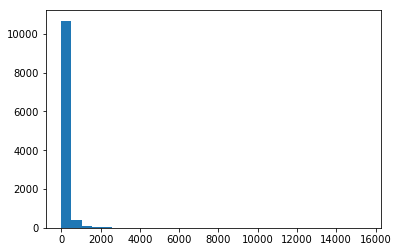

In [20]:
_ = plt.hist(train_news_length, bins=30)

In [21]:
test_news_length = [len(item) for item in test_news_vecs]
#Sort the testing news vectors by its length
news_lens_pair = list(zip(test_news_length, test_news_vecs, test_news_labels))
news_lens_pair.sort()
test_news_vecs_sorted = [item[1] for item in news_lens_pair]
test_news_labels_sorted = [item[2] for item in news_lens_pair]

In [22]:
train_news_length_sorted = [len(item) for item in train_news_vecs_sorted]

In [23]:
#Filter those very long or very short texts
#Filter out those very long or very short news
train_data = []
train_label = []
test_data = []
test_label = []
for i, news in enumerate(train_news_vecs_sorted):
    if len(news) > 10 and len(news)  < 400:
        train_data.append(news)
        train_label.append(train_news_labels_sorted[i])
for i, news in enumerate(test_news_vecs_sorted):
    if len(news)  > 10 and len(news)  < 400:
        test_data.append(news)
        test_label.append(test_news_labels_sorted[i])

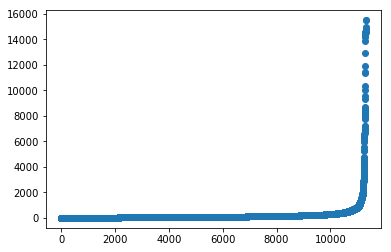

In [24]:
#The lengths of news
plt.scatter(range(len(train_news_length_sorted)), train_news_length_sorted)

## Create Bucket Batch Generator

In [27]:
class generateSamples:
    '''Generate samples for training and testing'''
    
    def __init__(self, batch_size, news_vecs, news_labels, weights, max_len=1000):
        '''Pass batch size and poems vectors'''
        self.index = 0
        self.batch_size = batch_size
        self.news_vecs = news_vecs
        self.news_labels = news_labels
        self.weights= weights
        self.news_count = len(news_vecs)
        self.max_len = max_len
        
    def generate_batch(self, is_training=True):
        '''Generate a training sample each time'''
        start = self.index%self.news_count
        end = (start + self.batch_size)%self.news_count
        #In case end goes beyong the range of the samples
        if end > start:
            data = self.news_vecs[start: end]
            label = self.news_labels[start: end]
            #record weights
            batch_weight = self.weights[start:end]
            self.index = end
        else:
            if is_training:#Continue to make new samples
                self.index = end
                data = self.news_vecs[start: ] + self.news_vecs[: end]
                #record weights
                batch_weight = self.weights[start:] + self.weights[: end]
                #record labels
                label = np.zeros(self.batch_size)
                label[end:] = self.news_labels[start: ] 
                label[:end] = self.news_labels[:end]
            else:#End making new samples
                print('Test Samples come to an end!')
                data = self.news_vecs[start: ]
                #record weights
                batch_weight = self.weights[start:]
                label = self.news_labels[start: ]
                self.index = 0
        #Set the max lengths as the size of the input
        #max_len = max(map(len, data))
        max_len = self.max_len
        #Record lengths for each text
        lengths = [len(item) for item in data]
        lengths = np.array(lengths)

        sample_num = len(data)
        #Create input and label
        x = np.full((sample_num,max_len), word2id('UNK'), np.int32)
        w = np.full((sample_num,max_len), 0, np.float32)
        y = np.zeros(sample_num)
        for i in range(sample_num):
            #the first n elements as input
            x[i, :len(data[i])] = data[i]
            w[i, :len(data[i])] = batch_weight[i]
            y[i] = label[i]
        return x, y, lengths, w
    

From the data exploration, it is clear that the length of the news varies much, ranging from 10 to 10000. In order to deal with that case, we can take buckets into consideration, similar to seq2seq model.

In [16]:
#Set several buckets in advance
buckets = [120, 190, 305, 510, 800]

In [17]:
def data2buckets(news_vecs, news_labels, news_weights):
    bucket_data = [[] for _ in range(len(buckets))]
    for i, vec in enumerate(news_vecs):
        label = news_labels[i]
        w = news_weights[i]
        #If the news is too long, cut the tail
        #And put it into the last bucket
        if len(vec) > buckets[-1]:
            vec = vec[:buckets[-1]]
            w = w[:buckets[-1]]
            #bucket_data[-1].append((vec, label, w))
        #Otherwise, put it into the other bucket
        else:
            for l, b in enumerate(buckets):
                if len(vec) <= b:
                    bucket_data[l].append((vec, label, w))
                    break
    return bucket_data

In [18]:
#Separate original data into buckets
bucket_data = data2buckets(train_news_vecs, train_news_labels, train_weights)
bucket_data_test = data2buckets(test_news_vecs, test_news_labels, test_weights)
# Print summaries of buckets
train_bucket_sizes = [len(bucket_data[b]) for b in range(len(buckets))]
train_total_size = float(sum(train_bucket_sizes))
for ix, bucket in enumerate(bucket_data):
    print('Data pts in bucket {}: {}'.format(ix, len(bucket)))

Data pts in bucket 0: 3044
Data pts in bucket 1: 2866
Data pts in bucket 2: 2651
Data pts in bucket 3: 1630
Data pts in bucket 4: 589


In [19]:
import random
class generateBucketSamples:
    '''Generate samples for training'''
    
    def __init__(self, batch_size, bucket_data, buckets):
        '''Pass batch size and poems vectors'''
        self.index = 0
        self.batch_size = batch_size
        self.bucket_data = bucket_data
        self.buckets = buckets
        
        
    def generate_batch(self, bucket_id, is_training=True):
        '''Generate a training sample each time'''
        
        #The size of the specified bucket
        bucket_len = self.buckets[bucket_id]
        bucket_sample = []
        for _ in range(self.batch_size):
            if is_training:
                vec, label, w = random.choice(self.bucket_data[bucket_id])
            else:
                #During testing, fetch each sampleone by one
                vec, label, w = self.bucket_data[bucket_id][self.index]
                self.index += self.batch_size
                if self.index > bucket_len:
                    self.index = 0
            ID = word_id_map['UNK']
            #Pad the vec with 'unk' index
            #To make the vec the same length
            left = bucket_len - len(vec)
            vec = vec + [ID] * left
            w = w + [0] * left
            bucket_sample.append((vec, label, w))
        vecs, labels, weights = zip(*bucket_sample)
        vecs = np.array(vecs, np.int32)
        labels = np.array(labels, np.int32)
        weights = np.array(weights, np.float32)
        return vecs, labels, weights      

In [20]:
class trainConfig:
    vocab_size = len(vocab)
    max_doc_len = max(map(len, train_news_vecs))
    label_size = 20
    embed_size = 128
    batch_size = 64
    layer_size = 2

In [21]:
class testConfig:
    vocab_size = len(vocab)
    max_doc_len = max(map(len, train_news_vecs))
    label_size = 20
    embed_size = 128
    batch_size = 1
    layer_size = 2

In [23]:
train_chunk_num = int(len(train_news_vecs)/trainConfig.batch_size)
test_chunk_num = int(len(test_news_vecs)/trainConfig.batch_size)
remain_num = len(test_news_labels) - trainConfig.batch_size*test_chunk_num
remain_num

44

In [24]:
train_samples = generateBucketSamples(trainConfig.batch_size, bucket_data, buckets)

In [25]:
test_samples = generateBucketSamples(testConfig.batch_size, bucket_data_test, buckets)

## Bag of Word2Vec Model

In this model, we first transform each news as a series of word vectors. Then we represent each news with the average vector for those word vectors. Next, we do classification based on the news vectors.

In [26]:
import functools
from tensorflow.contrib.layers.python.layers import encoders
def lazy_property(function):
    attribute = '_cache_' + function.__name__

    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)

    return decorator

In [69]:
class BOW_Bucket_Model:
    def __init__(self, config, x, y, weight, bucket_size, is_training=True):
        self.x = x
        self.y = y
        self.vocab_size = config.vocab_size
        self.embed_size = config.embed_size
        self.label_size = config.label_size
        self.max_doc_len = config.max_doc_len
        self.word_weights = weight
        self.bucket_size = bucket_size
        self.is_training = is_training
        self.predict
        if is_training:
            self.optimize
        print('Model Initialized!')
    
    @lazy_property
    def cost(self):
        logits = self.bow
        targets = tf.one_hot(self.y, 20, 1, 0)
        targets = tf.cast(targets, tf.float32)
        #Note  tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=activation)
        loss = tf.losses.softmax_cross_entropy(targets, logits)
        return loss
    
    @lazy_property
    def predict(self):
        logits = self.bow
        #probs = tf.nn.softmax(logits)
        predictions = tf.argmax(logits, 1)
        return predictions
    
    @lazy_property
    def correct_num(self):
        prediction = self.predict
        targets = tf.reshape(self.y, [-1])
        targets = tf.cast(targets, tf.int64)
        correct_prediction = tf.equal(prediction, targets)
        correct_num = tf.reduce_sum(tf.cast(correct_prediction, "float"))
        return correct_num
    
    @lazy_property
    def optimize(self):
        with tf.variable_scope('optimizer'):
            cost = self.cost
            self._learning_rate = tf.get_variable(name='learning_rate',  
                                                  shape=(), trainable=False)
            #train_op = tf.train.AdamOptimizer(0.0005).minimize(cost)
            train_op = tf.train.AdamOptimizer(self._learning_rate).minimize(cost)
            #tvars = tf.trainable_variables()
            #grads, _ = tf.clip_by_global_norm(tf.gradients(cost, tvars), 6)
            #optimizer = tf.train.AdamOptimizer(self._learning_rate)
            #train_op = optimizer.apply_gradients(zip(grads, tvars))
        return train_op
    
    @lazy_property
    def bow(self):
        #Create embedding matrix
        with tf.device("/cpu:0"):
            embeddings = tf.get_variable('embedding', [self.vocab_size,  self.embed_size])
            inputs = tf.nn.embedding_lookup(embeddings, self.x)
        if self.is_training:
            inputs = tf.nn.dropout(inputs, 0.5)
        #Take word tfidf weights into consideration
        w = tf.expand_dims(self.word_weights, -1)
        #Each vector is multiplied by a weight extracted by tfidf value
        inputs = inputs * w
        #slice inputs into a series of vectors
        batch_doc_vectors = tf.unstack(inputs, axis=0)
        vecs = []
        #Consider the real length of each news
        #Calculate the mean vector for each article, ignore the padding words
        for i, doc_vector in enumerate(batch_doc_vectors):
            doc = tf.reduce_mean(doc_vector[:self.bucket_size,:], axis=0)
            vecs.append(doc)
        mean_vector = tf.reshape(vecs, [len(vecs), self.embed_size])
        weights = tf.get_variable('weights', [self.embed_size, self.label_size], dtype=tf.float32)
        biases = tf.get_variable('biases', [self.label_size], dtype=tf.float32)
        logits = tf.matmul(mean_vector, weights) + biases
        #预测值
        return logits
    
    @property
    def learningRate(self):
        return self._learning_rate
        

In [70]:
graph_bow = tf.Graph()
#Create models for training and testing data
with graph_bow.as_default():
    initializer = tf.random_uniform_initializer(-0.02, 0.02)
    with tf.name_scope('train'):
        train_data = tf.placeholder(tf.int32, [trainConfig.batch_size, None])
        train_label = tf.placeholder(tf.int32, [trainConfig.batch_size])
        train_weight = tf.placeholder(tf.float32, [trainConfig.batch_size, None])
        train_models = [[] for _ in range(len(buckets))]
        #Set different models for different buckets
        with tf.variable_scope("Model", initializer=initializer):
            for i in range(len(buckets)):
                if i > 0: tf.get_variable_scope().reuse_variables()
                train_models[i] = BOW_Bucket_Model(trainConfig, train_data, train_label, train_weight, buckets[i])

Model Initialized!
Model Initialized!
Model Initialized!
Model Initialized!
Model Initialized!


In [71]:
with graph_bow.as_default():
    #Set models which share parameters with training models
    #Use different models of different buckets
    with tf.name_scope('test'):
        test_data = tf.placeholder(tf.int32, [testConfig.batch_size, None])
        test_label = tf.placeholder(tf.int32, [testConfig.batch_size])
        test_weight = tf.placeholder(tf.float32, [testConfig.batch_size, None])
        test_models = [[] for _ in range(len(buckets))]
        #Set different models for different buckets
        with tf.variable_scope("Model", reuse=True, initializer=initializer):
            for i in range(len(buckets)):
                test_models[i] = BOW_Bucket_Model(testConfig, test_data, test_label, test_weight, buckets[i], False)

Model Initialized!
Model Initialized!
Model Initialized!
Model Initialized!
Model Initialized!


In [75]:
epochs = 200
with tf.Session(graph=graph_bow) as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for l in range(epochs):
        #Use exponential decaying learning rate
        if l%4 == 0:
            sess.run(tf.assign(train_models[0].learningRate, 0.0005*(0.98**l)))
        for i in range(train_chunk_num):
            #Assign a learning rate
            #sess.run(tf.assign(model.isTraining, True))
            bucket_id = np.random.choice(len(buckets))
            vecs, labels, weights = train_samples.generate_batch(bucket_id)
            feed_dict = {train_data:vecs, train_label:labels, train_weight:weights}
            loss, _ = sess.run([train_models[bucket_id].cost, train_models[bucket_id].optimize], feed_dict=feed_dict)
            if i% 200 == 0:
                print('Loss:', loss)
    #Traverse each bucket of testing data
    print('*' * 20)
    print('Testing Accuracy:')
    count = 0
    test_samples = generateBucketSamples(testConfig.batch_size, bucket_data_test, buckets)
    for bucket_id in range(len(buckets)):
        #Traverse each data within each bucket
        for _ in bucket_data_test[bucket_id]:
            vecs, labels, weights = test_samples.generate_batch(bucket_id)
            feed_dict = {test_data:vecs, test_label:labels, test_weight:weights}
            n = sess.run(test_models[bucket_id].correct_num, feed_dict=feed_dict)
            count += np.sum(n)
    print(count*1.0/len(newsgroups_test.data))

Loss: 2.99686
Loss: 2.99264
Loss: 2.99046
Loss: 2.97904
Loss: 2.96003
Loss: 2.95199
Loss: 2.93158
Loss: 2.88982
Loss: 2.8694
Loss: 2.8217
Loss: 2.77338
Loss: 2.74565
Loss: 2.69408
Loss: 2.71487
Loss: 2.64425
Loss: 2.63463
Loss: 2.56541
Loss: 2.52304
Loss: 2.48622
Loss: 2.49776
Loss: 2.45684
Loss: 2.38483
Loss: 2.29243
Loss: 2.25605
Loss: 2.22366
Loss: 2.21989
Loss: 2.25813
Loss: 2.19509
Loss: 2.03479
Loss: 2.15299
Loss: 1.96263
Loss: 1.90216
Loss: 1.88647
Loss: 1.84296
Loss: 1.91052
Loss: 1.81769
Loss: 1.85548
Loss: 1.79239
Loss: 1.78705
Loss: 1.66843
Loss: 1.5514
Loss: 1.66907
Loss: 1.61898
Loss: 1.56734
Loss: 1.44452
Loss: 1.5823
Loss: 1.56734
Loss: 1.48477
Loss: 1.57264
Loss: 1.55625
Loss: 1.28785
Loss: 1.4796
Loss: 1.31148
Loss: 1.34747
Loss: 1.39199
Loss: 1.28521
Loss: 1.37644
Loss: 1.35803
Loss: 1.19545
Loss: 1.11193
Loss: 1.47585
Loss: 1.37158
Loss: 1.1752
Loss: 1.42552
Loss: 1.1787
Loss: 1.23715
Loss: 1.24391
Loss: 1.1557
Loss: 1.11033
Loss: 1.16471
Loss: 1.03435
Loss: 1.28534
